<a href="https://colab.research.google.com/github/11harini04/MDSProject/blob/master/Web_scraping_NSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install influxdb-client

     |████████████████████████████████| 491kB 1.4MB/s 
     |████████████████████████████████| 112kB 44.7MB/s 
     |████████████████████████████████| 512kB 48.0MB/s 
  Created wheel for ciso8601: filename=ciso8601-2.1.3-cp36-cp36m-linux_x86_64.whl size=28305 sha256=55fdfcfc174be157f72c43b5dc8f5763b69701f0b5b70e85040e8f5127c7fa88
  Stored in directory: /root/.cache/pip/wheels/eb/32/e4/13bdaf7e245f82667b21e0cfb03d21224691a47fa9f9bc80a6
  Created wheel for rx: filename=Rx-3.1.0-cp36-none-any.whl size=195489 sha256=63b3faded18e07b2e87610b909fe20105d602aa86d9399773c6e0422ae0268b7
  Stored in directory: /root/.cache/pip/wheels/88/84/32/3daff4afe52d5372cf3691233c2f29f8b498b034f4ef994d0a
Successfully built ciso8601 rx
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9


In [0]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client import InfluxDBClient

bucket = "_tasks"
org = "11harini04@gmail.com"
token = "A11NbY2ifqR8sQGdC8KUtXsmd-5gvFk8ruvlBzdyyFfDmb7bBRVzhoDf2_dOq5WL9J5EQBQpp2oL2vdGRCR8Uw=="
client = InfluxDBClient(url="https://us-west-2-1.aws.cloud2.influxdata.com",token=token)

In [0]:
import requests
import pandas as pd
from datetime import datetime
from bokeh.plotting import figure, show, output_file
from influxdb_client import Point

#Use this API key itself, idhu ennoda email id la pota API
API_KEY = 'GIJPOQVYSQTTJ319'
#stocks = ['INFY','NLCINDIA.BO','AAPL']
stocks = ['NLCINDIA.BO']
for i in range(len(stocks)):

  #Scraping data from YahooFinance
  stock_name = stocks[i]
  r = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=' + stock_name + '&apikey=' + API_KEY)
  result = r.json()
  dataForAllDays = result['Time Series (Daily)']

  #convert to dataframe
  df = pd.DataFrame.from_dict(dataForAllDays, orient='index') 
  #df = df.reset_index()
  
  #rename columns
  df = df.rename(index=str, columns={"index":"name", "1. open": "open", "2. high": "high", "3. low": "low", "4. close": "close","5. volume":"volume"})

  #Changing the datatype 
  df.open = df.open.astype(float)
  df.close = df.close.astype(float)
  df.high = df.high.astype(float)
  df.low = df.low.astype(float)
  df.volume = df.volume.astype(int)
  name = [stock_name]*len(df)  
  df['name'] = name
  print(df['name'][0])
  kind = 'Stock'
  date = []
  for ind in df.index:
    datetime_object = datetime.strptime(ind,'%Y-%m-%d')
    #print(datetime_object)
    date.append(datetime_object)
    point = Point(kind).tag("name",df['name'][ind]).field("open",df['open'][ind]).field("close",df['close'][ind]).field("high",df['high'][ind]).field("low",df['low'][ind]).time(time = datetime_object)
    #print(f'Writing to InfluxDB cloud: {point.to_line_protocol()} ...')
    write_api = client.write_api(write_options = SYNCHRONOUS)
    write_api.write(bucket = bucket, org = org, record = point)
  df['Date'] = date
  df.set_index("Date", inplace = True) 

NLCINDIA.BO


In [0]:
query = 'from(bucket: "_tasks") |> range(start: -1h)'
tables = client.query_api().query(query, org=org)
for table in tables:
  print(table)
  for row in table.records  :
    print(row.values)

In [0]:
df

,open,high,low,close,volume,name
Date,,,,,,
2020-04-07,43.50,45.00,43.50,44.10,18373,NLCINDIA.BO
2020-04-03,43.60,44.05,42.80,43.60,20121,NLCINDIA.BO
2020-04-01,43.60,44.70,43.05,43.20,21470,NLCINDIA.BO
2020-03-31,43.15,44.40,43.15,44.00,23853,NLCINDIA.BO
2020-03-30,41.55,43.50,40.45,43.15,53378,NLCINDIA.BO
...,...,...,...,...,...,...
2019-11-19,53.35,54.00,53.10,53.40,31837,NLCINDIA.BO
2019-11-18,54.75,54.75,52.75,53.55,111380,NLCINDIA.BO
2019-11-15,54.50,54.75,54.20,54.25,16764,NLCINDIA.BO


In [0]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(df['close'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=368.760, BIC=381.089, Fit time=0.734 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=397.641, BIC=402.573, Fit time=0.029 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=375.128, BIC=384.991, Fit time=0.271 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=367.012, BIC=376.876, Fit time=0.469 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=368.596, BIC=380.926, Fit time=0.554 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=397.475, BIC=404.873, Fit time=0.095 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=368.598, BIC=380.928, Fit time=1.040 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=370.593, BIC=385.389, Fit time=1.842 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=365.896, BIC=373.293, Fit time=0.311 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 

In [0]:
stepwise_model_fit = stepwise_model.fit(df['close'])
forecast = stepwise_model_fit.predict(n_periods=10)
print(forecast)

[53.81548834 53.68219972 53.07891354 53.0884848  52.76373661 52.45743359
 53.0216596  51.89791407 51.86603985 51.54325236]


Text(0.5, 1.0, 'Forecasted plot of Closing price for next 10 days')

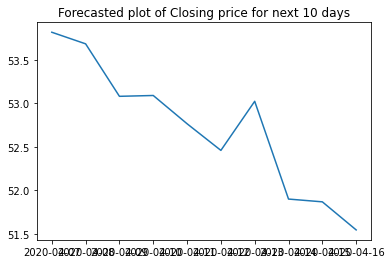

In [0]:
import matplotlib.pyplot as plt
dates = []
for i in range(7,17):
  s = '2020-04-'
  if(len(str(i))==1):
    s = s + '0' + str(i)
  else:
    s = s + str(i)
  dates.append(s)
plt.plot(dates,forecast)
plt.title('Forecasted plot of Closing price for next 10 days')

In [0]:
pip install --ignore-installed --upgrade keras

     |████████████████████████████████| 378kB 4.4MB/s 
     |████████████████████████████████| 2.9MB 7.6MB/s 
     |████████████████████████████████| 26.1MB 1.3MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 20.2MB 142kB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 276kB 46.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=cbe46f14dc3c720f141e0ac46640185cd4306d50e756abf24e5bdd70efc3a44f
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
ERROR: qtconsole 4.7.2 has requirement pyzmq>=17.1, but you'll have pyzmq 17.0.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ER

In [0]:

#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt



/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [0]:
df = web.DataReader('NLCINDIA.BO', data_source='yahoo', start='2013-01-01', end='2020-04-04')


In [0]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-01,81.650002,80.599998,81.099998,81.250000,5914.0,51.378613
2013-01-02,82.000000,79.599998,81.650002,80.199997,40535.0,50.714642
2013-01-03,82.449997,80.400002,80.699997,81.849998,21731.0,51.758022
2013-01-04,83.650002,81.099998,81.599998,83.250000,38319.0,52.643322
2013-01-07,87.500000,83.300003,83.300003,85.800003,149125.0,54.255810
...,...,...,...,...,...,...
2020-03-27,42.400002,40.700001,41.099998,41.900002,62162.0,41.900002
2020-03-30,43.500000,40.450001,41.549999,43.150002,53378.0,43.150002
2020-03-31,44.400002,43.150002,43.150002,44.000000,23853.0,44.000000


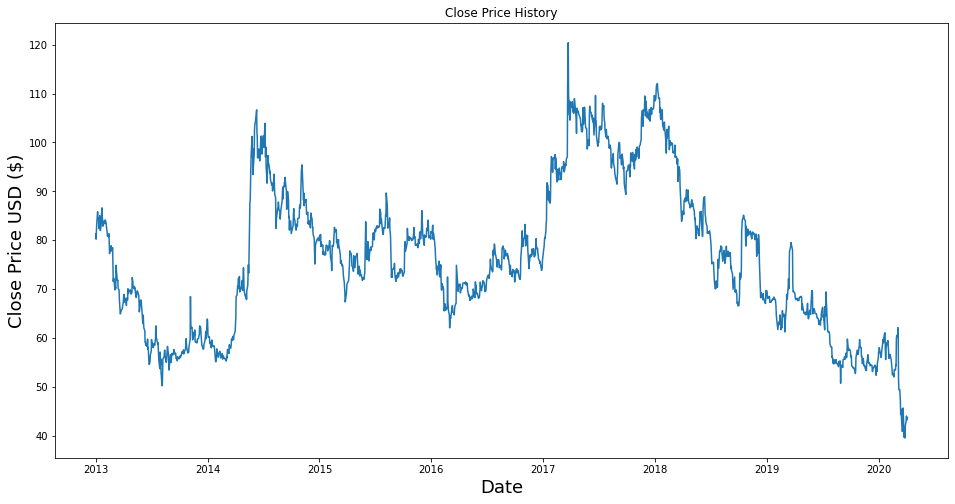

In [0]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [0]:
data = df.filter(['Close'])

dataset = data.values

training_data_len = math.ceil( len(dataset) * .8 )

training_data_len

1428

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.51606921],
       [0.50309019],
       [0.52348576],
       ...,
       [0.05562423],
       [0.04573548],
       [0.05067983]])

In [0]:
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.51606921, 0.50309019, 0.52348576, 0.54079109, 0.57231152,
       0.55624226, 0.55624226, 0.55191595, 0.52966623, 0.56242273,
       0.55129787, 0.52472183, 0.53213847, 0.53461062, 0.58220022,
       0.56118666, 0.55315203, 0.5358467 , 0.54017301, 0.54882572,
       0.54758964, 0.54202716, 0.54697156, 0.55191595, 0.54264525,
       0.53213847, 0.525958  , 0.5216316 , 0.51050683, 0.51359706,
       0.50927066, 0.5166873 , 0.49381948, 0.46662545, 0.48084055,
       0.48022247, 0.48640294, 0.47342401, 0.47342401, 0.48145854,
       0.44128549, 0.39616814, 0.40358468, 0.40420267, 0.3794808 ,
       0.3745365 , 0.38195304, 0.37824472, 0.43695918, 0.40976515,
       0.39987636, 0.3980222 , 0.39925837, 0.37824472, 0.3745365 ,
       0.35105069, 0.33868975, 0.3220025 , 0.31396787, 0.32138442])]
[0.3238565692716475]

[array([0.51606921, 0.50309019, 0.52348576, 0.54079109, 0.57231152,
       0.55624226, 0.55624226, 0.55191595, 0.52966623, 0.56242273,
       0.55129787, 0.52472183, 0.532

In [0]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [0]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1368, 60, 1)

In [0]:

#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [0]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1368/1368 [==============================] - 51s 37ms/step - loss: 0.0037


In [0]:
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [0]:
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

2.526270344362891

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


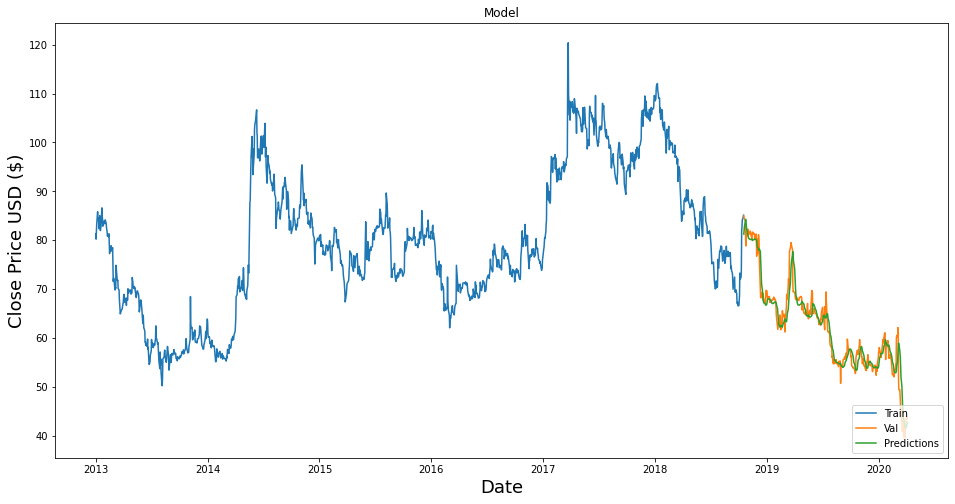

In [0]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [0]:
valid

In [0]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 10.4MB 8.0MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.25.3 which is incompatible.
  Found existing installation: pandas 1.0.3
    Uninstalling pandas-1.0.3:
      Successfully uninstalled pandas-1.0.3


In [0]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


In [0]:
mu = expected_returns.mean_historical_return(df['close'])        
S = risk_models.sample_cov(df['close'])           
ef = EfficientFrontier(mu, S)        
raw_weights = ef.max_sharpe()        
cleaned_weights = ef.clean_weights()        
perf = ef.portfolio_performance(verbose=True)        
ef.__dict__

Expected annual return: 67.3%
Annual volatility: 54.8%
Sharpe Ratio: 1.19


/usr/local/lib/python3.6/dist-packages/pypfopt/expected_returns.py:67: RuntimeWarning: prices are not in a dataframe
  warnings.warn("prices are not in a dataframe", RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/pypfopt/risk_models.py:61: RuntimeWarning: prices are not in a dataframe
  warnings.warn("prices are not in a dataframe", RuntimeWarning)


{'_additional_constraints_raw': [],
 '_additional_objectives': [],
 '_constraints': [Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
  Equality(Expression(AFFINE, UNKNOWN, ()), Variable(())),
  Inequality(Constant(CONSTANT, ZERO, ())),
  Inequality(Expression(AFFINE, ZERO, (1,))),
  Inequality(Variable((1,)))],
 '_lower_bounds': array([0]),
 '_objective': Expression(CONVEX, NONNEGATIVE, (1, 1)),
 '_upper_bounds': array([1]),
 '_w': Variable((1,)),
 'cov_matrix': array([[0.29982626]]),
 'expected_returns': array([0.67309985]),
 'n_assets': 1,
 'tickers': ['close'],
 'weights': array([1.])}